In [1]:
# Part-A
#Airbnb Price Prediction Project
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [10]:
#Load Dataset from Google Sheets

sheet_url = "https://docs.google.com/spreadsheets/d/1N7P0euUjfjB8XXdTBQeicjGjxAOm18wvCRLaQC92a8g/export?format=csv"
df = pd.read_csv(sheet_url)

print("Dataset Loaded Successfully!")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()


Dataset Loaded Successfully!
Rows: 74111, Columns: 29


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [3]:
# Data Preprocessing

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Drop columns with too many missing values
df = df.dropna(thresh=len(df)*0.6, axis=1)

# Fill remaining missing numeric values with median, categorical with mode
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Convert host_response_rate from percentage to numeric (if exists)
if 'host_response_rate' in df.columns:
    df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float)

# Convert boolean-like text to 1/0
bool_cols = ['cleaning_fee', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).map({'t': 1, 'f': 0, 'True': 1, 'False': 0})

# Drop non-useful columns (IDs, text descriptions, URLs)
drop_cols = ['id', 'name', 'description', 'thumbnail_url', 'amenities']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Handle categorical columns with Label Encoding
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])



Missing Values per Column:
id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     968
bedrooms                     91
beds                        131
dtype: int64


In [4]:
print(df.isnull().sum())

log_price                 0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64


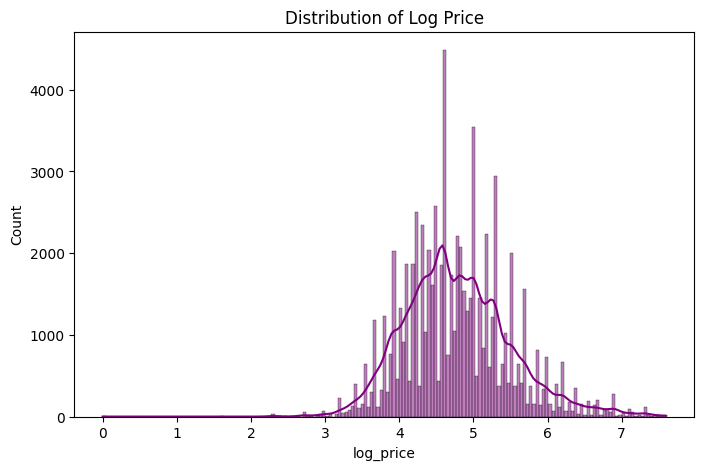

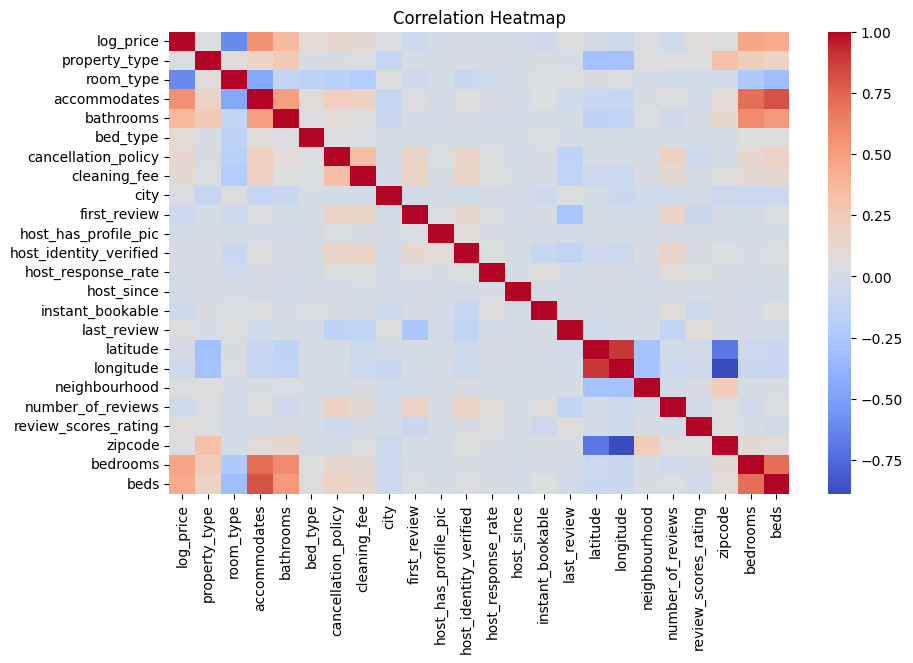

In [5]:

# Exploratory Data Analysis

plt.figure(figsize=(8,5))
sns.histplot(df['log_price'], kde=True, color='purple')
plt.title('Distribution of Log Price')
plt.show()

plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Train-Test Split

X = df.drop('log_price', axis=1)
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training (Random Forest Regressor)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [11]:
# Model Evaluation

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Model Performance Metrics:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


 Model Performance Metrics:
MAE  : 0.285
RMSE : 0.395
R²   : 0.696


/tmp/ipython-input-389710102.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


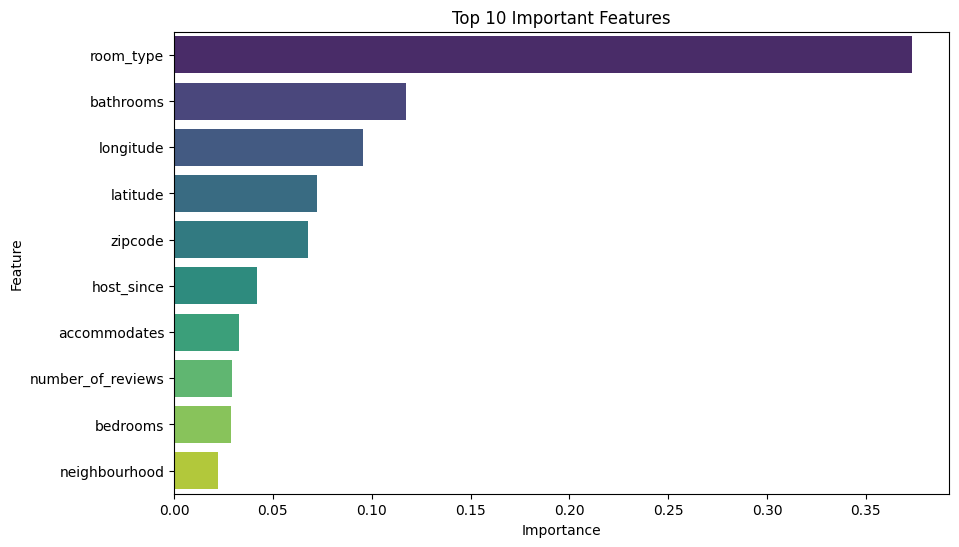

In [8]:
# Feature Importance

importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
importance = importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Top 10 Important Features')
plt.show()


In [12]:

# Save the Model


import joblib
joblib.dump(model, 'airbnb_price_model.pkl')
print(" Model saved as airbnb_price_model.pkl")


 Model saved as airbnb_price_model.pkl
